## Benchmarking


I'm using this code to benchmark underlying function and my code generation tactics

will use a 2B1T + FWTD model and relise it at 20 m/s & 5 deg aoa

In [1]:
import pandas as pd
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
from scipy.linalg import eig
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.RectWing.Models as rwm
import multiprocessing as mp

me.mechanics_printing()

In [12]:

%%time
flutdf = pd.DataFrame()
b_modes = 3
t_modes = 3

ls = []
for i in [0]:
#for i in range(8):
    for j in ["WT","JEC","HALE"]:
        dat = pd.read_pickle(f'fp_data_{b_modes}B{t_modes}T-M{i}_{j}.pkl')
        dat['Model'] = i
        dat['Config'] = j
        ls.append(dat)
    
flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Coast Angle [Deg]'] = (np.rad2deg([i[-1] for i in flutdf['q']]))
flutdf['FWT Mass [%]'] = pd.Categorical(flutdf['delta_m']*100)
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['Model'] = pd.Categorical(flutdf['Model'])
flutdf['Config'] = pd.Categorical(flutdf['Config'])
flutdf['c_dmax'] = pd.Categorical(flutdf['c_dmax'])
flutdf['Locked'] = pd.Categorical((flutdf['k_fwt']>0).map({True:"Locked",False:"Free"}))
flutdf['Mode'] =0

CPU times: user 35 ms, sys: 7.37 ms, total: 42.4 ms
Wall time: 41.4 ms


In [13]:
flutdf['Locked'].unique()

[Free, Locked]
Categories (2, object): [Free, Locked]

### Load all test data into a singe dataframe

In [14]:
def GetReducedDataSet(flutdf,model_num,Config = ["JEC"],Flare=25,FWT_mass = [100],AoA=0,c_dmax = 0,V = None,Locked = "Free"):
    data = flutdf.copy()
    data = data[cpo.SeriesFilter(data['Model'],model_num)]
    data = data[cpo.SeriesFilter(data['Flare Angle [Deg]'],Flare)]
    data = data[cpo.SeriesFilter(data['FWT Mass [%]'],FWT_mass)]
    data = data[cpo.SeriesFilter(data['AoA [Deg]'],AoA)]
    data = data[cpo.SeriesFilter(data['Config'],Config)]
    data = data[cpo.SeriesFilter(data['V'],V)]
    
    data = data[cpo.SeriesFilter(data['c_dmax'],c_dmax)]
    data = data[cpo.SeriesFilter(data['Locked'],Locked)]
    return data

In [15]:
targets = []

# get Lift target
from scipy.interpolate import interp1d
cruise_aoa = 3
cruise_v = 50

tar_data = GetReducedDataSet(flutdf,0,Config = ["JEC"],Flare=17.5,FWT_mass = [100],V=[cruise_v],
                             AoA=None,c_dmax = 0,Locked = ["Locked"])
aoa = np.array(tar_data['AoA [Deg]'])
lift = np.array(tar_data['Lift'])
q = np.array([ list(i) for i in tar_data['q']]).T

func = interp1d(aoa,lift)
q_func = interp1d(lift,q)

lift_target = int(np.round(func(cruise_aoa)))

series = tar_data.iloc[0].copy()
series['alpha_r'] = np.deg2rad(cruise_aoa)
series['q'] = q_func(cruise_aoa)
series['Lift'] = lift_target
targets.append(series.to_dict())

lift_target

In [8]:
# create dict of points
tar_data = GetReducedDataSet(flutdf,0,Config = ["JEC"],Flare=17.5,FWT_mass = [100],V=[cruise_v],
                             AoA=None,c_dmax = 0,Locked = ["Free"])
aoa = np.array(tar_data['AoA [Deg]'])
lift = np.array(tar_data['Lift'])
q = np.array([ list(i) for i in tar_data['q']]).T

aoa_func = interp1d(lift,aoa)
q_func = interp1d(lift,q)
series = tar_data.iloc[0].copy()
series['alpha_r'] = np.deg2rad(aoa_func(lift_target))
series['q'] = q_func(lift_target)
series['Lift'] = lift_target
targets.append(series.to_dict())

targets

[{'V': 50.0,
  'alpha_r': 0.05235987755982989,
  'delta_m': 1.0,
  'c_dmax': 0.0,
  'k_fwt': 10000000.0,
  'Lambda': 0.30543261909900765,
  'Lift': 11208,
  'q': array([-4.13532888e-03, -1.19400388e-03,  6.88171236e-05, -1.51194415e-06,
          1.00611553e-03, -4.93915362e-05, -2.16163070e-07,  9.33702160e-03]),
  'Model': 0,
  'Config': 'JEC',
  'Coast Angle [Deg]': 2.4133451723387562,
  'FWT Mass [%]': 100.0,
  'Flare Angle [Deg]': 17.5,
  'AoA [Deg]': -5.0,
  'Locked': 'Locked',
  'Mode': 0},
 {'V': 50.0,
  'alpha_r': 0.05214299715272845,
  'delta_m': 1.0,
  'c_dmax': 0.0,
  'k_fwt': 0.0,
  'Lambda': 0.30543261909900765,
  'Lift': 11208,
  'q': array([ 7.06967112e-03,  1.92966668e-03, -1.25219009e-04,  3.01920688e-06,
          2.48236868e-03, -1.21862747e-04, -5.33334810e-07, -5.74996969e-03]),
  'Model': 0,
  'Config': 'JEC',
  'Coast Angle [Deg]': 25.301927681656526,
  'FWT Mass [%]': 100.0,
  'Flare Angle [Deg]': 17.5,
  'AoA [Deg]': -5.0,
  'Locked': 'Free',
  'Mode': 0}]

In [9]:
def GustTimeResponse(b_modes,t_modes,model_file,gust_strength,gust_period,fp_dict,att_index,end_time):
    print(f'Attitude {att_index},Strength {gust_strength}, Period {gust_period} - Starting')
    p = rw.JEC_params(b_modes+t_modes+2)      
    sm = mf.SymbolicModel.from_file(model_file)    
    nm = sm_mini.CreateNumericModel(p)
    
    # set attitude parameters
    tup = p.GetTuple()
    for k,v in fp_dict.items():
        for s in tup:
            if isinstance(s,mf.ModelSymbol):
                if s.name == k:
                    s.value = v

    #Define the Gust Function
    def gust(t,x):
        if t<gust_period:
            return gust_strength*0.5*(1- np.cos(2*np.pi*t/gust_period))
        else:
            return 0
    p.w_g.value = gust
    
    # Define Objective Function for solver
    def objectiveDeriv(t,y):
        tup = p.GetNumericTuple(y,t)
        return nm.deriv(t,y,tup)

    # Generate I.C. and run the solver
    x = [0]*p.qs*2
    x[::2] = fp_dict['q']
    yData = solve_ivp(objectiveDeriv,(0,end_time),x)

    #interpolate to reduce t and y points
    int_func = interp1d(yData.t,yData.y)

    t = np.linspace(0,end_time,(end_time*100)+1)
    yi = int_func(t)
    
    
    #Package Results
    # remove q from dict
    var = {k:v for k,v in fp_dict.items() if k !='q'}
    
    #generate functions for values of interest
    z,_ = mf.ShapeFunctions_BN_TM(b_modes,0,p.q[1:b_modes+1],p.y_0,0,0,0,p.eta[1:b_modes+1])

    d2z_dy2 = z.diff(p.y_0,p.y_0).subs(p.y_0,0)
    z_tip = z.subs(p.y_0,p.s_0)
    dz_dy_tip = z.diff(p.y_0).subs(p.y_0,p.s_0)

    d2z_dy2_f = sym.lambdify((p.GetTuple(),p.q),d2z_dy2)
    z_tip_f = sym.lambdify((p.GetTuple(),p.q),z_tip)
    dz_dy_tip_f = sym.lambdify((p.GetTuple(),p.q),dz_dy_tip)

    tup = p.GetNumericTuple(None,0)
    wrbm = d2z_dy2_f(tup,yi[::2])*p.EI.value
    wrbm_max = max(wrbm)
    wrbm_min = min(wrbm)
    inner_tip_deflection = z_tip_f(tup,yi[::2])
    fold_angle = np.rad2deg((yi[-2])+dz_dy_tip_f(tup,yi[::2]))
        
    ls = []
    for i in range(len(t)):
        lift = nm.ExtForces(p.GetNumericTuple(yi[:,i],t[i]),yi[:,i],t[i])[0,0]

        ls.append({'t':t[i],'q':yi[:,i],'Gust Strength':gust_strength,
                   'Gust Period':gust_period,**var,'Attitude':att_index,
                   'Delta WRBM':wrbm[i]-wrbm[0],
                   'WRBM Max':wrbm_max,'WRBM Min':wrbm_min,
                   'WRBM':wrbm[i],'Inner Tip Deflection':inner_tip_deflection[i],
                  'Fold Angle':fold_angle[i],'Lift':lift})
    return ls

In [10]:
b_modes = 3
t_modes = 3
model_num = 0

dataset_name = 'JEC'
p = rw.base_params(b_modes + t_modes + 2)
p.rho.value = 1.225
p.s_t.value = 12
p.c.value = 1.8
p.EI.value = 9.77e6
p.GJ.value = 0.99e6
p.rho_t.value = 19.53
p.e_0.value = 0.08
p.e_1.value = 0  
p.ratio_fwt.value = 0.2

p.alpha_s.value = np.deg2rad(15)
p.eta.value = [1]*p.qs
p.m_ac.value = 1e6
p.k_ac.value = 1e6
p.k_fwt.value = 0    

vars_ls =[]
vars_ls.append((p.V,[50]))
vars_ls.append((p.alpha_r,np.deg2rad([4])))
vars_ls.append((p.m_factor,[1]))
vars_ls.append((p.c_dmax,[1]))
vars_ls.append((p.k_fwt,[0,1e7]))
vars_ls.append((p.Lambda,np.deg2rad([17.5])))
variables = [k for k,v in vars_ls]

In [11]:
w_max = [1]
w_T = np.linspace(0.5,3,6)

sm = mf.SymbolicModel.from_file(f'{b_modes}B{t_modes}T-M{model_num}.py')
sm_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables+[p.w_g]))
sm_mini.to_file('Temp_Model.py')

pool = mp.Pool(mp.cpu_count())

res =[]
for T in w_T:
    for M in w_max:
        for i in range(len(targets)):
            res.append(pool.apply_async(GustTimeResponse, args = (3,3,'Temp_Model.py',M,T,targets[i],i,4)))

pool.close()
pool.join()


ls = []
for i in res:
    ls += i.get()
df = pd.DataFrame(ls)
print('Complete')

Attitude 0,Strength 1, Period 0.5 - Starting
Attitude 1,Strength 1, Period 0.5 - Starting
Attitude 0,Strength 1, Period 1.0 - Starting
Attitude 1,Strength 1, Period 1.0 - Starting
Attitude 0,Strength 1, Period 1.5 - Starting
Attitude 1,Strength 1, Period 1.5 - Starting
Attitude 0,Strength 1, Period 2.0 - Starting
Attitude 1,Strength 1, Period 2.0 - Starting
Attitude 0,Strength 1, Period 2.5 - Starting
Attitude 1,Strength 1, Period 2.5 - Starting
Attitude 0,Strength 1, Period 3.0 - Starting
Attitude 1,Strength 1, Period 3.0 - Starting
Complete


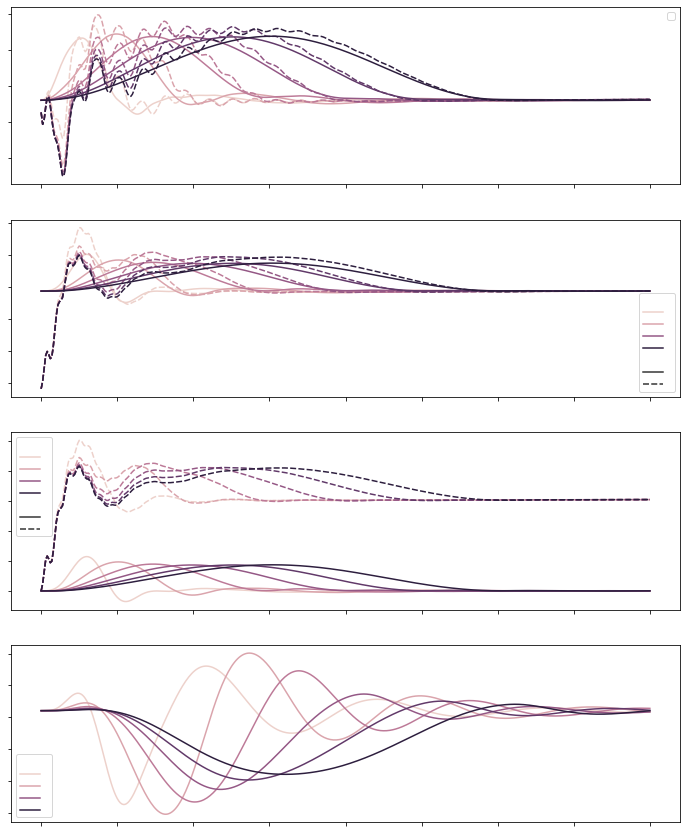

In [20]:
data = df.copy()
data = data[data['Gust Strength']==1]
data['Locked'] = data['k_fwt']>0

fig, axes = plt.subplots(4,1,figsize=(12,15))

sns.lineplot(data = data, x = 't',y='Lift',hue = 'Gust Period',style = 'Locked',ax = axes[0])
sns.lineplot(data = data, x = 't',y='WRBM',hue = 'Gust Period',style = 'Locked',ax = axes[1])
sns.lineplot(data = data, x = 't',y='Delta WRBM',hue = 'Gust Period',style = 'Locked',ax = axes[2])
sns.lineplot(data = data[data['Locked']==False], x = 't',y='Fold Angle',hue = 'Gust Period',ax = axes[3])

axes[0].legend([])
#axes[2].legend([])
#axes[3].legend([])
df['Fold Angle'].max()

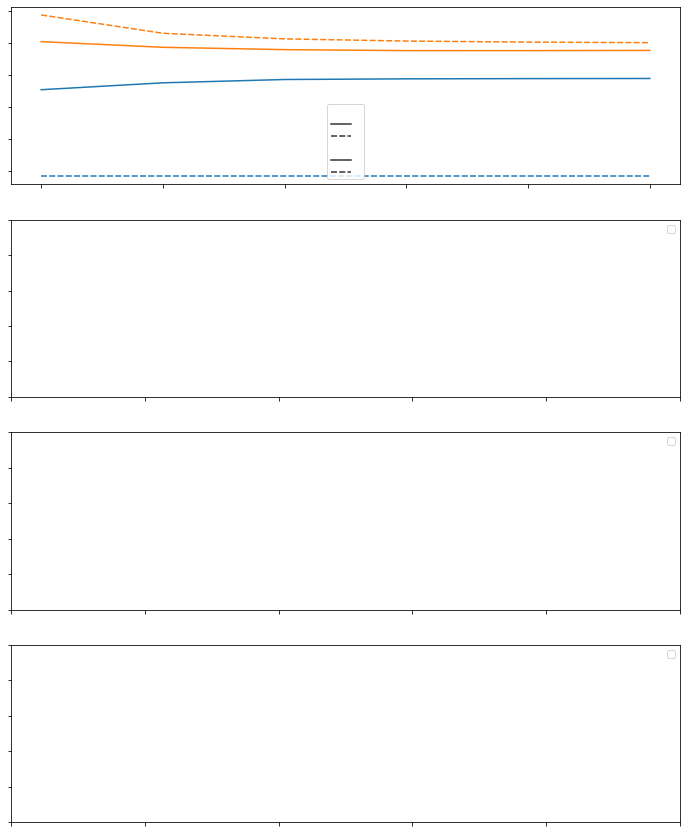

In [21]:
data = df.copy()
data = data[data['Gust Strength']==1]
data = data[data['t']==0]
data['Locked'] = data['k_fwt']>0

fig, axes = plt.subplots(4,1,figsize=(12,15))

sns.lineplot(data = data, x='Gust Period',y='WRBM Min',style = 'Locked',ax=axes[0])
sns.lineplot(data = data, x='Gust Period',y='WRBM Max',style = 'Locked',ax=axes[0])
#sns.lineplot(data = data, x = 't',y='Lift',hue = 'Gust Period',style = 'Locked',ax = axes[0])
#sns.lineplot(data = data, x = 't',y='WRBM',hue = 'Gust Period',style = 'Locked',ax = axes[1])
#sns.lineplot(data = data, x = 't',y='Delta WRBM',hue = 'Gust Period',style = 'Locked',ax = axes[2])
#sns.lineplot(data = data, x = 't',y='Fold Angle',hue = 'Gust Period',style = 'Locked',ax = axes[3])

axes[1].legend([])
axes[2].legend([])
axes[3].legend([])
df['Fold Angle'].max()